# On the Distribution of the Smallest Indices 

[Earlier](https://timvieira.github.io/blog/post/2021/03/18/on-the-distribution-functions-of-order-statistics/), I wrote about the distribution functions of order statistics.  Today, we will look at the distribution of rankings, $R_{(1)}, \ldots, R_{(n)}$: the indices of the smallest to largest items. Let $Z_{1}, \ldots, Z_{n}$ be independent random variables distribution functions $F_1, \ldots F_n$ and density functions $f_1, \ldots f_n$.

The ranking is generated as follows:
$$
\begin{align*}
& Z_{1} \sim F_1; \ldots; Z_{n} \sim F_n \\
& R_{(1)}, \ldots, R_{(n)} = \mathrm{argsort}\left( Z_{1}, \ldots, Z_{n} \right)
\end{align*}
$$

We will look at

- the probability mass function for the (unordered) set of $K$ smallest elements, $Y_{(K)} = \{ R_{(1)}, \ldots, R_{(K)} \}$

- the probability that index $i$ is included in $Y_{(K)}$

I care about the inclusion probabilities because they are crucial to estimation under sampling without replacement designs [(Vieira, 2017)](https://timvieira.github.io/blog/post/2017/07/03/estimating-means-in-a-finite-universe/).  Previously, I was only able to (efficiently) use noisy estimates of the inclusion probabilities.  This post develops an algorithm for efficiently approximating the inclusion probabilities of ordered sampling without replacement designs.  The algorithm will require a one-dimensional numerical quadrature, which is preferable to summing over permutations.  

The probability of the set $R_{(k)}$ is useful for other estimators, e.g., [Kool+ (2020)](https://arxiv.org/abs/2002.06043).

As with yesterday's post, I'd like to acknowledge that my derivation and implementation draws heavily on [Aires (1999)](https://link.springer.com/article/10.1023/A:1010091628740) and [Traat+ (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0378375803001502).

## PMF of $Y_{(K)}$ .

We can also compute the probability mass function for the entire set.
$$
\begin{align*}
\mathrm{Pr}\left( Y_{(k)} = y \right) 
&=
\int_t \sum_{j}
\mathrm{Pr}\left( Z_j = t, R_{(k)} = j, Y_{(k)} = y\right) \\
&= 
\int_{t}
\sum_{j \in y}
f_j(t) 
\prod_{i \in y: i \ne j} F_i(t) 
\prod_{i \in \overline{y}: i \ne j} (1-F_i(t)) 
\end{align*}
$$

The sum $j \in y$ partitions the event space by which index $j$ is the is the $k^{\mathrm{th}}$ smallest element, $R_{(k)} = j$.  Now, with $j$ is fixed, we integrate over the density of values $t$ that $Z_j$ can take on.  Since $j$ is decided as the $k^{\mathrm{th}}$, it must be in the set.  Additionally, we don't want to multiply the probability of $t$ twice, so we exclude $j$ for the two products.  $\prod_{i \in y: i \ne j} F_i(t)$ is the probability that all $i \in y$ that aren't $i=j$ are larger than the threshold $t$.  It is a product because they are independently drawn.  Similarly, the other product is the probability that $i \in \overline{y}: i \ne j$ are all smaller.

As a minor touch up on this formula to simplify implementation, we apply a change of variables $t=F^{-1}_j(u)$ to integrate over $u \in [0, 1]$ instead of $t \in \mathrm{domain}(Z_i)$.  The change of variables formula means that we end up dividing by the density because of the usual "determinant of the Jacobian thing," $\frac{d t }{d u} = \frac{d}{d u} F^{-1}_j(u) = \frac{1}{f_j(t)}$ by the [inverse function theorem](https://en.wikipedia.org/wiki/Inverse_function_theorem)).  Our final result is
$$
\int_0^1
\sum_{j \in y}
\prod_{i \in y: i \ne j} F_i(F^{-1}_j(u)) \prod_{i \in \overline{y}: i \ne j} (1-F_i(F^{-1}_j(u))) \, du
$$

Although this equation involves an integral, it is a massive speedup over summing permutations of the indices.  I should say that in some exceptional cases, the integral may simplify further. This equation is implemented and tested in the Code and Tests sections.

Lastly, I'd like to give a shout-out to Dan Marthaler, a helpful commenter on this blog, who pointed out that the PMF of the multivariate noncentral hypergeometric distribution would help evaluate the PMF of the Gumbel sorting scheme.  I'd also like to point out that Appendix B of [Kool+2020](https://arxiv.org/abs/2002.06043) gives a very similar derivation for the PMF of the Gumbel sorting scheme.  My version gives a generic recipe for any collection of independent variables, not just Gumbels.  The general case does not have closed-form integrals, so using numerical integration may be the best we can do.

## Inclusion probabilities

We can also ask for the inclusion probability of $i$ in the bottom $k$ (i.e., the set of $k$ smallest indices).  Let $Y_{(k)} = \{ R_{(1)}, \ldots, R_{(n)} \}$.
$$
\mathrm{Pr}\left( i \in Y_{(k)} \right) 
$$

Given the distribution function for the order statistics that we worked out [yesterday](https://timvieira.github.io/blog/post/2021/03/18/on-the-distribution-functions-of-order-statistics/), the inclusion probability of each item can be computed by the following integral ([Aires, 1999](https://link.springer.com/article/10.1023/A:1010091628740), Eq. 6).

$$
\begin{align*}
\mathrm{Pr}\left( i \in Y_{(k)} \right) 
&= \int_{t} f_i(t) \, \mathrm{Pr}\left[ \underset{{j \in [n]\smallsetminus\{i\}}}{\overset{(k-1)}{\mathrm{smallest}}}\ Z_j > t \right] \\
&= \int_{t} f_i(t) \, (1-F^{[n] \smallsetminus \{i\}}_{(k-1)}(t)) 
\end{align*}
$$

where $F^{[n] \smallsetminus \{i\}}_{(k-1)}$ is the distribution function of the $(k-1)^{\mathrm{th}}$ order statistic with index $i$ removed from the set $[n]\overset{\mathrm{def}}{=}\{1,\ldots,n\}$.  The reason for this removal is that have have forced $i$ to be in $Y_{(k)}$, so we're only sampling from what remains; namely, $(k-1)$ from the set of remaining elements $[n] \smallsetminus \{i\}$.

Now, integrating over the density of values $t$ of $Z_i$, we will cover all the ways that $i$ can be the $k^{\mathrm{th}}$ smallest element.

As a final step, we apply a change of variables $t = F^{-1}_i(u)$ to make the integral over $u$ from $0$ to $1$ instead of t, which ranges over the entire domain of $Z_i$.  (See the earlier explanation for with the pdf disappears.) 
$$
= 1 - \int_0^1 F^{[n] \smallsetminus \{i\}}_{(k-1)}(F^{-1}_i(u)) \, du
$$

## Code

Code from [order statistics post](https://timvieira.github.io/blog/post/2021/03/18/on-the-distribution-functions-of-order-statistics/).

In [1]:
import numpy as np
from numba import njit

class Ordered:
    def __init__(self, ds: 'list of distributions'):
        self.ds = ds
    def rvs(self, size=None):
        return np.sort(self.sample_keys(size), axis=0)
    def sample_keys(self, size=None):
        return np.array([d.rvs(size) for d in self.ds])
    def cdf(self, t):
        "Evaluate the CDF of the order statistics."
        return C(np.array([d.cdf(t) for d in self.ds]))[1:]
    def pdf(self, K, t):
        "Evaluate the PDF of the order statistics."
        # We implement a more efficient expression than we derived above
        # by manually applying algorithmic differentiation.
        _, d_p = d_C(np.array([d.cdf(t) for d in self.ds]), K+1)   # off-by-one due to shift in cdf
        return sum(d_p[n] * self.ds[n].pdf(t) for n in range(len(self.ds)))

@njit    
def B(p):
    "Sum of weighted sets of size == k."
    q = 1-p
    N = len(p)
    F = np.zeros((N+1,N+1))
    F[:,0] = 1
    for n in range(N):
        F[n+1,0] = q[n] * F[n,0]
    for k in range(1, N+1):
        for n in range(N):
            F[n+1,k] = q[n] * F[n,k] + p[n] * F[n,k-1]
    return F[N,:]

@njit
def C(p):
    "Sum of weighted sets of size >= k."
    N = len(p)
    b = B(p)
    c = np.zeros(N+2)
    for j in range(N, -1, -1):
        c[j] += c[j+1]
        c[j] += b[j]
    return c

New code

In [2]:
from scipy.integrate import quadrature

class Ranks:
    
    def __init__(self, ds: 'list of distributions'):
        self.ds = ds
        
    def sample_indices(self, size=None):
        return np.argsort(self.sample_keys(size), axis=0).T
    
    def sample_keys(self, size=None):
        return np.array([d.rvs(size) for d in self.ds])
 
    def inclusion(self, i, K):
        "Pr[ i \in Y_{(K)} ]"
        if K == len(self.ds): return np.ones(len(self.ds))
        target = self.ds[i].ppf
        ds = list(self.ds); ds.pop(i)   # remove i from the ensemble
        F = Ordered(ds).cdf
        return 1-quadrature(lambda u: F(target(u))[K-1], 0, 1,
                            maxiter=200, vec_func=False)[0]

    def pmf(self, y):
        "Pr[ Y_{(K)} = y ]"
        return quadrature(lambda u: self._pmf(y, u), 0, 1, maxiter=200)[0]

    def _pmf(self, y, u):
        c = 0.0
        ds = self.ds
        N = len(ds)
        for j in y:
            t = ds[j].ppf(u)
            z = 1.0
            for i in range(N):
                if i == j: pass
                elif i in y:
                    z *= ds[i].cdf(t)
                else:
                    z *= ds[i].sf(t)
            c += z
        return c

## Tests

Below, we test out our analytical method for computing the distribution function of independent normal distributions.  The method should work for any collection of distributions in `scipy.stats`.  You can even mix and match the distribution types.  We will compare the analytical $F_{(k)}$ to the empirical distribution of $Z_{(k)}$ using a large sample size.

In [3]:
import scipy.stats as st, numpy as np, pylab as pl
from numpy.random import uniform
np.random.seed(123456)
N = 8
m = Ranks([st.norm(uniform(-1, 1), uniform(0, 1)) for i in range(N)])

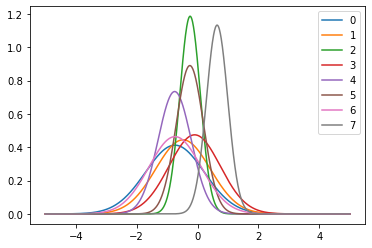

In [4]:
ts = np.linspace(-5, 5, 1000)
for i in range(N):
    pl.plot(ts, m.ds[i].pdf(ts), label=i)
pl.legend(loc='best');

In [5]:
from arsenal import ok, warn
from collections import Counter

reps = 10_000
tol = reps**-0.5

K = 3
#K = int(np.random.randint(1, N+1))
print(f'N={N}, K={K}')

pmf_ = Counter()
incl_ = np.zeros(N)
Rs = m.sample_indices(reps)
for r in range(reps):
    x = np.zeros(N)
    x[Rs[r, :K]] = 1
    incl_ += x / reps
    pmf_[frozenset(Rs[r, :K])] += 1/reps
    
# sanity check: incl probs for a size K sample should sum to K
assert np.allclose(incl_.sum(), K)  

N=8, K=3


Below, we compare Monte Carlo inclusion probabilities to our numerical integration approach.

In [6]:
for i in np.argsort(-incl_):
    have = m.inclusion(i, K)
    print(f'{i:-2d}: {have:.4f}, {incl_[i]:.4f}', 
          ok if 0.5*abs(have - incl_[i]) <= tol else warn)

 4: 0.6408, 0.6454 ok
 6: 0.5872, 0.5864 ok
 0: 0.5799, 0.5746 ok
 1: 0.4595, 0.4570 ok
 3: 0.2776, 0.2790 ok
 5: 0.2489, 0.2479 ok
 2: 0.2040, 0.2071 ok
 7: 0.0021, 0.0026 ok


Below, we compare the Monte Carlo estimate of the PMF to our numerical integration approach.

In [7]:
for Y in sorted(pmf_, key=lambda Y: -pmf_[Y]):
    want = pmf_[Y]
    have = m.pmf(Y)
    print(f'{Y}: {have:.4f}, {want:.4f}', 
          ok if 0.5*abs(have - want) <= tol else warn)

frozenset({0, 4, 6}): 0.1286, 0.1261 ok
frozenset({0, 1, 4}): 0.0847, 0.0851 ok
frozenset({1, 4, 6}): 0.0856, 0.0850 ok
frozenset({0, 1, 6}): 0.0783, 0.0778 ok
frozenset({0, 3, 4}): 0.0430, 0.0448 ok
frozenset({3, 4, 6}): 0.0437, 0.0437 ok
frozenset({4, 5, 6}): 0.0398, 0.0425 ok
frozenset({0, 3, 6}): 0.0390, 0.0392 ok
frozenset({0, 4, 5}): 0.0382, 0.0363 ok
frozenset({2, 4, 6}): 0.0331, 0.0354 ok
frozenset({0, 2, 4}): 0.0312, 0.0321 ok
frozenset({0, 5, 6}): 0.0301, 0.0290 ok
frozenset({1, 3, 4}): 0.0284, 0.0274 ok
frozenset({0, 1, 3}): 0.0256, 0.0249 ok
frozenset({1, 3, 6}): 0.0255, 0.0249 ok
frozenset({1, 4, 5}): 0.0255, 0.0248 ok
frozenset({0, 2, 6}): 0.0224, 0.0216 ok
frozenset({1, 2, 4}): 0.0209, 0.0215 ok
frozenset({0, 1, 5}): 0.0193, 0.0205 ok
frozenset({1, 5, 6}): 0.0198, 0.0191 ok
frozenset({1, 2, 6}): 0.0148, 0.0160 ok
frozenset({3, 4, 5}): 0.0131, 0.0147 ok
frozenset({0, 1, 2}): 0.0142, 0.0127 ok
frozenset({2, 4, 5}): 0.0131, 0.0126 ok
frozenset({2, 3, 4}): 0.0108, 0.0119 ok


## Closing 

This Jupyter notebook is available for [download](https://github.com/timvieira/blog/blob/master/content/Distribution-of-Smallest-Indices.ipynb).

I am very happy to answer questions! There are many ways to do that: comment at the end of this document, Tweet at [@xtimv](https://twitter.com/xtimv), or email tim.f.vieira@gmail.com.

If you found this article interesting please consider sharing it on social media. If you found this article useful please cite it

```bibtex
@misc{vieira2021smallest,
  author = {Tim Vieira},
  title = {On the Distribution of the Smallest Indices},
  year = {2021},
  url = {https://timvieira.github.io/blog/post/2021/03/20/on-the-distribution-of-the-smallest-indices/}
}
```